In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

In [198]:
suj = 'antisacadas_91'
df = pd.read_csv(f'./raw_data/{suj}.csv')
df.head(5)

rt                                           stimulus  \
0   1006.0  \n    <div style="left: calc(50% - 400px); wid...   
1   7178.0                                                NaN   
2    709.0  \n    <div style="left: calc(50% - 400px); wid...   
3  46036.0                                                NaN   
4   5546.0  \n    <div style="left: calc(50% - 400px); wid...   

                                            response            trial_type  \
0                                                  0  html-button-response   
1  {"anteojos":"no","age":"33","hand":"derecha","...      survey-html-form   
2                                                  0  html-button-response   
3                                                NaN      virtual-chinrest   
4                                                  0  html-button-response   

   trial_index  time_elapsed internal_node_id  run_id  condition  \
0            0          1010          0.0-0.0      91          1   
1            1          8193          0.0-1.0      91          1   
2            2          8904          0.0-2.0      91          1   
3            3         54943          0.0-3.0      91          1   
4            4         60493          0.0-4.0      91          1   

           recorded_at               source_code_version  ip  \
0  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
1  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
2  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
3  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
4  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   

                                          user_agent  device browser  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
1  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
2  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
3  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
4  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   

  browser_version platform  platform_version  item_width_mm  item_height_mm  \
0       107.0.0.0    Linux               NaN            NaN             NaN   
1       107.0.0.0    Linux               NaN            NaN             NaN   
2       107.0.0.0    Linux               NaN            NaN             NaN   
3       107.0.0.0    Linux               NaN           85.6           53.98   
4       107.0.0.0    Linux               NaN            NaN             NaN   

   item_width_px  px2mm  view_dist_mm  item_width_deg  px2deg  win_width_deg  \
0            NaN    NaN           NaN             NaN     NaN            NaN   
1            NaN    NaN           NaN             NaN     NaN            NaN   
2            NaN    NaN           NaN             NaN     NaN            NaN   
3          312.0   3.64        505.91         9.67142   32.26      52.076875   
4            NaN    NaN           NaN             NaN     NaN            NaN   

   win_height_deg success timeout failed_images failed_audio failed_video  \
0             NaN     NaN     NaN           NaN          NaN          NaN   
1             NaN     NaN     NaN           NaN          NaN          NaN   
2             NaN     NaN     NaN           NaN          NaN          NaN   
3       26.720397     NaN     NaN           NaN          NaN          NaN   
4             NaN     NaN     NaN           NaN          NaN          NaN   

  jspsych_start_time  load_time response_type key_press  avg_frame_time  \
0                NaN        NaN           NaN       NaN             NaN   
1                NaN        NaN           NaN       NaN             NaN   
2                NaN        NaN           NaN       NaN             NaN   
3                NaN        NaN           NaN       NaN             NaN   
4                NaN        NaN           NaN       NaN             NaN   

   center_x  center_y rastoc-type stimulus-coordina

In [199]:
len(df.query("not webgazer_data.isnull() and isTutorial == False"))

# 340 trials totales
# 20 son de practica

320

In [45]:
# ALGO CON ESTO SE DEBERIA PODER HACER


df_saccade = df.query("not webgazer_data.isnull()")
webgazer_data = df_saccade['webgazer_data'].map(eval)
df_saccade['cueShownAtLeft']

# webgazer_data_left = df.query("not webgazer_data.isnull() and typeOfSaccade == 'antisaccade' and cueShownAtLeft == True")['webgazer_data'].map(eval)
# webgazer_data_right = df.query("not webgazer_data.isnull() and typeOfSaccade == 'antisaccade' and cueShownAtLeft == False")['webgazer_data'].map(eval)
                    
# for lista in webgazer_data_left:
#     for diccionario in lista:
#         diccionario['x'] = diccionario['x']* -1

# df_left = webgazer_data_left.to_frame()
# df_right = webgazer_data_right.to_frame()

# webgazer_frames = [df_left, df_right]
# webgazer_data = pd.concat(webgazer_frames).sort_index()['webgazer_data']
        

29       NaN
30       NaN
31       NaN
32       NaN
33       NaN
       ...  
654    False
655     True
656     True
657     True
658    False
Name: cueShownAtLeft, Length: 424, dtype: object

In [167]:
a = np.random.randn(5)
a

array([ 0.84969464, -0.46034315,  0.46023325, -0.90806267,  1.3796522 ])

In [168]:
np.where(a>0)

(array([0, 2, 4]),)

In [264]:
def pre_processing(
    df: pd.DataFrame,
    type_of_saccade: str,
    NEW_SAMPLING_RATE=30,
    interpolate=False,
    normalize=False,
    cue_shown_at_left=None,
    threshold_to_accept_sacc = 0.5
) -> None:
    """Plot webcam eye tracking data

    Args:
        df (pd.DataFrame): Webcam eye-tracking data
        type_of_saccade (str): `prosaccade` or `antisaccade`
        NEW_SAMPLING_RATE (int, optional): _description_. Defaults to 30.
        interpolate (bool, optional): _description_. Defaults to False.
        normalize (bool, optional): _description_. Defaults to False.
        cue_shown_at_left (_type_, optional): _description_. Defaults to None.

    Returns:
        Tuple: time and x-coordinates data
    """
    # 0. Estoy sacando los trials de practica (`isTutorial`)
    df_saccade = df.query(
        "not webgazer_data.isnull() and typeOfSaccade == @type_of_saccade and isTutorial == False"
    ) 

    print("type_of_saccade:", type_of_saccade)
    webgazer_data = df_saccade["webgazer_data"].map(eval)
    
    ts_xs = []
    baseline_start = -200.0
    baseline_end = 100.0
    pro_sacc_errors  = 0
    anti_sacc_errors  = 0

    for trial in range(len(webgazer_data)):


        t0 = df_saccade["intraEnd"].iloc[trial]
        tf = df_saccade["fixEnd"].iloc[trial]  # Deberia ser t0 - 200
        xs = np.array([i["x"] for i in webgazer_data.iloc[trial]])
        ts = np.array([i["t"] - t0 for i in webgazer_data.iloc[trial]])

        # 1. Calcular la mediana (o media, podes probar) entre [-200 0] = Xbase
        x_base = np.mean(xs[(ts > baseline_start) & (ts < baseline_end)]) # [-200, 100]

        # 2. Calcular la mediana entre [500 700] (se puede probar) = Xmax (o Xmin segun el signo)
        x_max = np.median(xs[(ts > 500.0) & (ts < 700.0)])

        # 3. y despues transformas tal que antes de 0 sea 0 y al final sea 1 o -1
        # eso seria: (xs - Xbase) / abs(Xbase - Xmax)
        xs = (xs - x_base) / np.abs(x_base - x_max)

        # 4. Luego de normalizar las estimaciones se espejó la mitad de ellas tal que pudiera asu-
        # mirse que el estímulo visual lateral aparecía siempre del mismo lado. El espejado se realizó
        # multiplicando por −1 las estimaciones de los ensayos en los cuales el estímulo lateral
        # apareciera a izquierda. -> Por lo tanto lo que quede para arriba es mirar en la direccion del estimulo y para abajo en la direccion opuesta
        if df_saccade["cueShownAtLeft"].iloc[trial] == True:
            xs = xs * -1

        # 5. filtro pasa banda de trials
        FILTER = 1.5
        if any(xs > FILTER) or any(xs < -FILTER):
            continue

        # 6. filtro sav gol
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
        xs = savgol_filter(xs, 5, 2)

        # 7. Detectar lado en que mira

        xs_after_baseline = xs[ts > baseline_end]
        if type_of_saccade == 'prosaccade':
            is_sacc_error_in_trial = np.any(xs_after_baseline < -threshold_to_accept_sacc)
            # print('trial: ', trial, "is_sacc_error_in_trial: ", is_sacc_error_in_trial)
            if is_sacc_error_in_trial:
                pro_sacc_errors += 1          
            # print(f"prosacadas correctas en trial {trial}: {np.sum(xs[ts > baseline_end] & xs[ts > baseline_end] > threshold_to_accept_sacc)}")
        elif type_of_saccade == 'antisaccade':
            is_anti_sacc_error_in_trial = np.any(xs_after_baseline > threshold_to_accept_sacc)
            # print('trial: ', trial, "is_anti_sacc_error_in_trial: ", is_anti_sacc_error_in_trial)
            if is_anti_sacc_error_in_trial:
                anti_sacc_errors += 1   

        # Normalize in range [-1, 1]
        if normalize:
            xs = normalize_in_range(xs, -1, 1)

        # Interpolate
        if interpolate:
            f1 = interp1d(ts, xs, kind="linear")
            ts_new = np.linspace(-200, ts[-1], NEW_SAMPLING_RATE)
            ts_xs.append((ts_new, f1(ts_new)))
        else:
            ts_xs.append((ts, xs))

    print(f"Trials rejected:{100 - (len(ts_xs)/len(webgazer_data) * 100) :.2f} %")
    print('pro_sacc_errors:', pro_sacc_errors)
    print('anti_sacc_errors:', anti_sacc_errors)

    return ts_xs, pro_sacc_errors, anti_sacc_errors


def normalize_in_range(values, a, b):
    """Normalize in range [a,b]"""
    values_normalized = []
    for i in range(len(values)):
        res = (
            (b - a) * ((values[i] - np.min(values))) / (np.max(values) - np.min(values))
        ) + a
        values_normalized.append(res)
    return np.array(values_normalized)


def one_subject(df, suj_number, type_of_saccade):
    suj_number = str(suj_number)
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        ts, xs = i[0], i[1]
        plt.plot(ts, xs)

    plt.title(f"{suj_number} {type_of_saccade}")
    plt.axhline(y=0.5, color='k', linestyle='-')
    plt.axhline(y=-0.5, color='k', linestyle='-')
    plt.ylabel("x coordinate (pxs)")
    plt.xlabel("time (ms)")
    # plt.xlim(-200, 1000)
    plt.ylim(-2, 2)
    plt.show()


In [271]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

df_processed_signal = pd.DataFrame(
    {
        "subject": None,
        "prosaccade": None,
        "antisaccade": None,
        "prosaccade_errors": None,
        "antisaccade_errors": None,
    },
    index=[],
)

subjects = []
pro_saccades = []
anti_saccades = []
pro_saccades_errors = []
anti_saccades_errors = []

print("processing ...")
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split("/")[-1].split(".")[0].split("_")[-1]
    anti_data, _, anti_sacc_errors = pre_processing(
        df, type_of_saccade="antisaccade", cue_shown_at_left=True
    )
    pro_data, pro_sacc_errors, _ = pre_processing(df, type_of_saccade="prosaccade", cue_shown_at_left=True)
    subjects.append(suj)
    pro_saccades.append(pro_data)
    anti_saccades.append(anti_data)
    pro_saccades_errors.append(pro_sacc_errors)
    anti_saccades_errors.append(anti_sacc_errors)
    print(" --- ")

df_processed_signal["subject"] = subjects
df_processed_signal["prosaccade"] = pro_saccades
df_processed_signal["antisaccade"] = anti_saccades
df_processed_signal["prosaccade_errors"] = pro_saccades_errors
df_processed_signal["antisaccade_errors"] = anti_saccades_errors
df_processed_signal["delta_errors"] = np.array(anti_saccades_errors) - np.array(pro_saccades_errors)

print(" ")
print("✅df_processed_signal ready✅")
df_processed_signal


processing ...
raw_data/antisacadas_99.csv
type_of_saccade: antisaccade
Trials rejected:15.00 %
pro_sacc_errors: 0
anti_sacc_errors: 9
type_of_saccade: prosaccade
Trials rejected:11.88 %
pro_sacc_errors: 2
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_91.csv
type_of_saccade: antisaccade
Trials rejected:13.12 %
pro_sacc_errors: 0
anti_sacc_errors: 8
type_of_saccade: prosaccade
Trials rejected:6.25 %
pro_sacc_errors: 6
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_101.csv
type_of_saccade: antisaccade
Trials rejected:33.12 %
pro_sacc_errors: 0
anti_sacc_errors: 3
type_of_saccade: prosaccade
Trials rejected:25.62 %
pro_sacc_errors: 1
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_104.csv
type_of_saccade: antisaccade
Trials rejected:10.00 %
pro_sacc_errors: 0
anti_sacc_errors: 11
type_of_saccade: prosaccade
Trials rejected:11.88 %
pro_sacc_errors: 5
anti_sacc_errors: 0
 --- 
raw_data/antisacadas_102.csv
type_of_saccade: antisaccade
Trials rejected:8.12 %
pro_sacc_errors: 0
anti_sacc_error

subject                                         prosaccade  \
0      99  [([-2382.0, -2308.0, -2271.0, -2213.0, -2153.0...   
1      91  [([-2168.0, -2112.0, -2063.0, -1989.0, -1940.0...   
2     101  [([-2280.0, -2243.0, -2194.0, -2143.0, -2083.0...   
3     104  [([-2434.0, -2369.0, -2342.0, -2295.0, -2238.0...   
4     102  [([-2452.0, -2375.0, -2327.0, -2279.0, -2227.0...   
5      92  [([-2133.0, -2068.0, -2038.0, -2010.0, -1962.0...   
6     105  [([-2107.0, -2066.0, -2015.0, -1966.0, -1914.0...   
7      98  [([-2085.0, -2016.0, -1977.0, -1919.0, -1890.0...   
8     100  [([-2348.0, -2286.0, -2257.0, -2204.0, -2131.0...   
9     103  [([-2296.0, -2235.0, -2182.0, -2132.0, -2083.0...   

                                         antisaccade  prosaccade_errors  \
0  [([-2259.0, -2196.0, -2138.0, -2087.0, -2007.0...                  2   
1  [([-2208.0, -2169.0, -2129.0, -2097.0, -2062.0...                  6   
2  [([-2410.0, -2351.0, -2307.0, -2249.0, -2199.0...                  1   
3  [([-2571.0, -2492.0, -2445.0, -2414.0, -2381.0...                  5   
4  [([-2456.0, -2396.0, -2360.0, -2328.0, -2295.0...                 19   
5  [([-2282.0, -2224.0, -2187.0, -2138.0, -2090.0...                  6   
6  [([-2573.0, -2518.0, -2479.0, -2427.0, -2393.0...                  0   
7  [([-2059.0, -1967.0, -1914.0, -1861.0, -1825.0...                  0   
8  [([-2297.0, -2213.0, -2160.0, -2105.0, -2070.0...                  6   
9  [([-2514.0, -2448.0, -2420.0, -2384.0, -2333.0...                  5   

   antisaccade_errors  delta_errors  
0                   9             7  
1                   8             2  
2                   3             2  
3                  11             6  
4                   4           -15  
5                   6             0  
6                   3             3  
7                   3             3  
8                   5            -1  
9                  11             6

<AxesSubplot: >

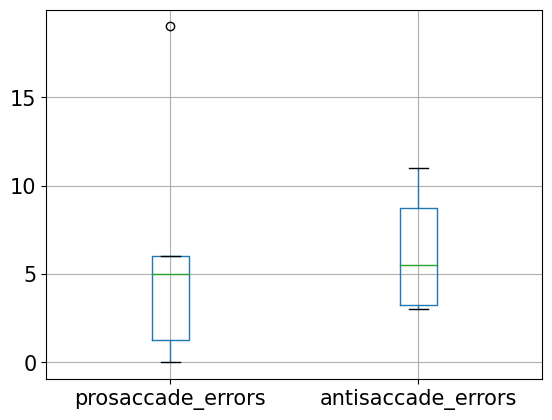

In [283]:
df_processed_signal.boxplot(column=['prosaccade_errors', 'antisaccade_errors'], fontsize=15)

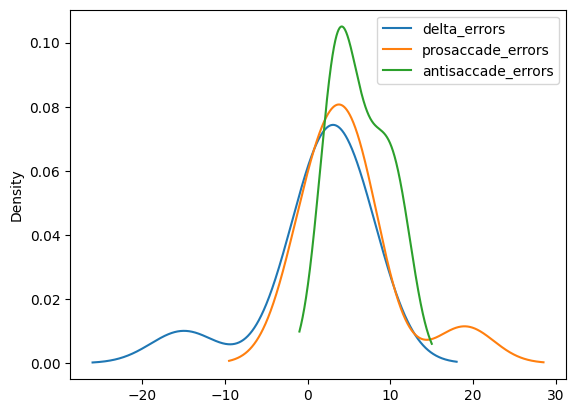

In [280]:
df_processed_signal['delta_errors'].plot.kde()
df_processed_signal['prosaccade_errors'].plot.kde()
df_processed_signal['antisaccade_errors'].plot.kde()
plt.legend()

---
99


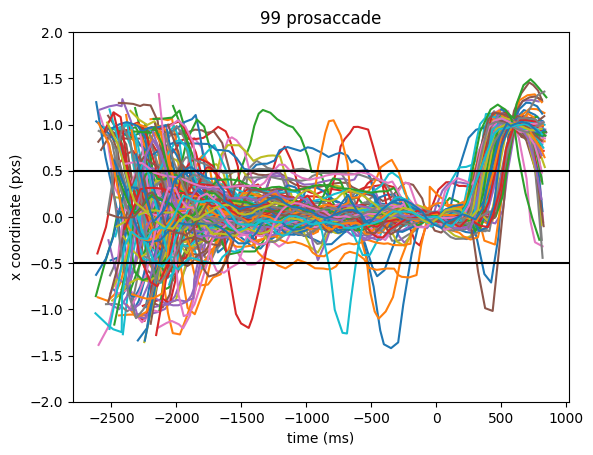

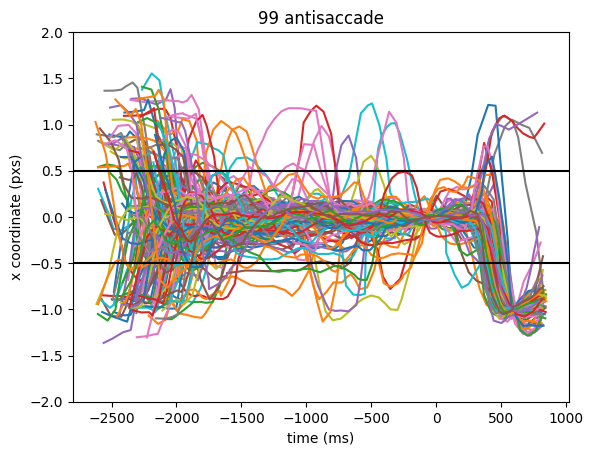

---
91


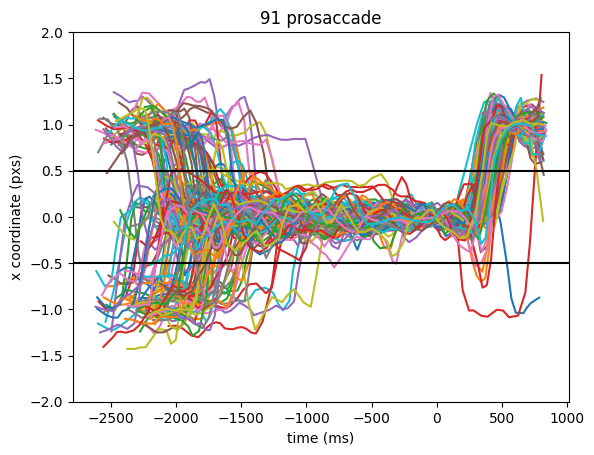

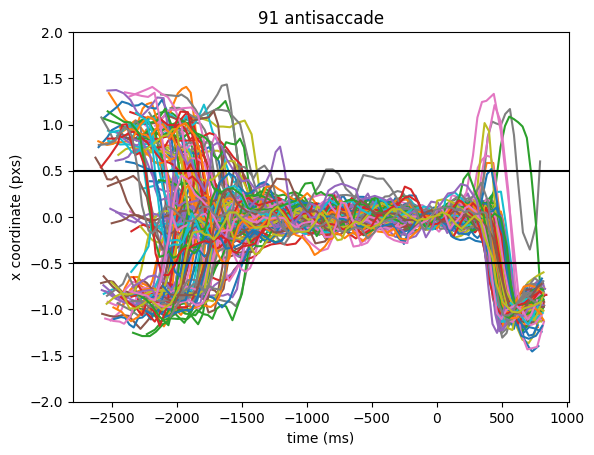

---
101


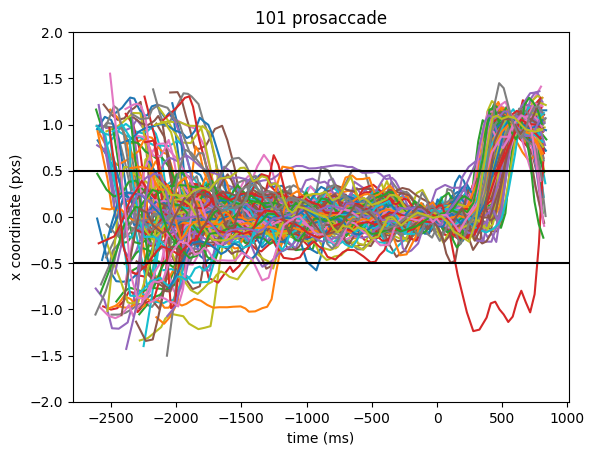

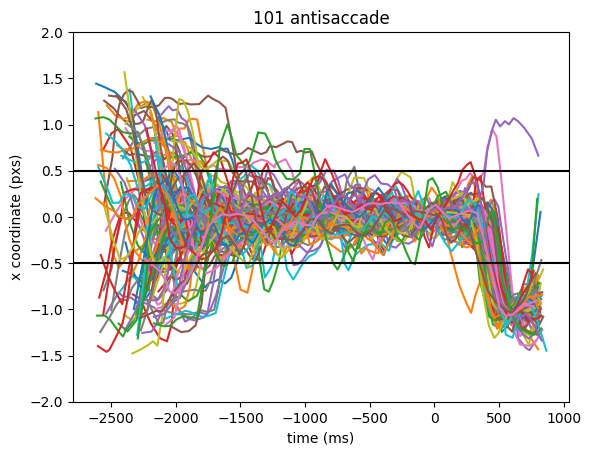

---
104


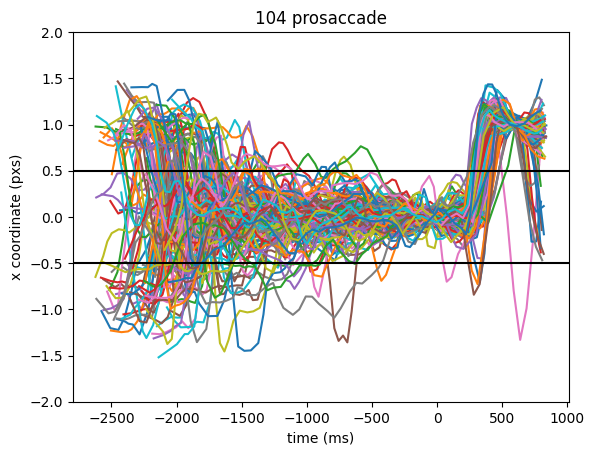

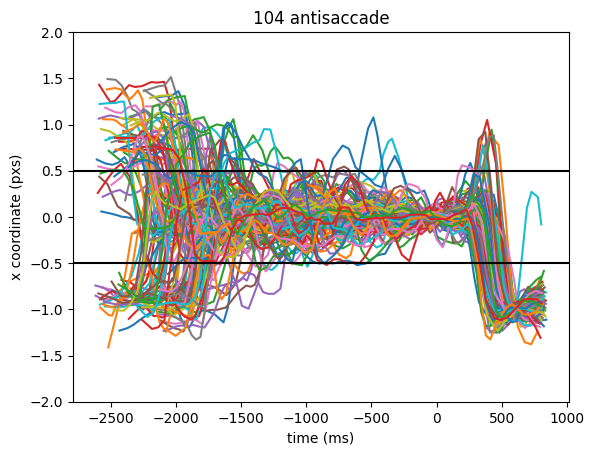

---
102


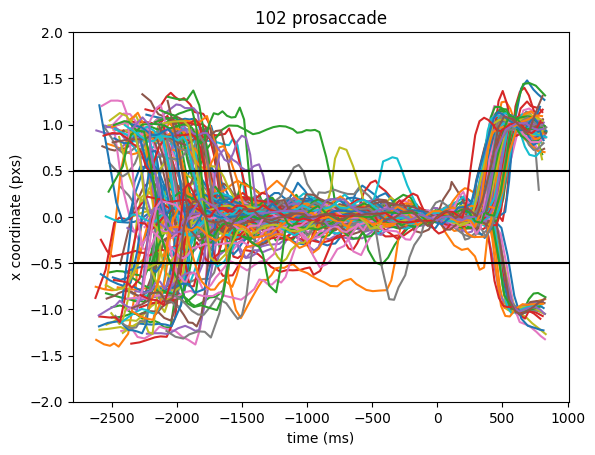

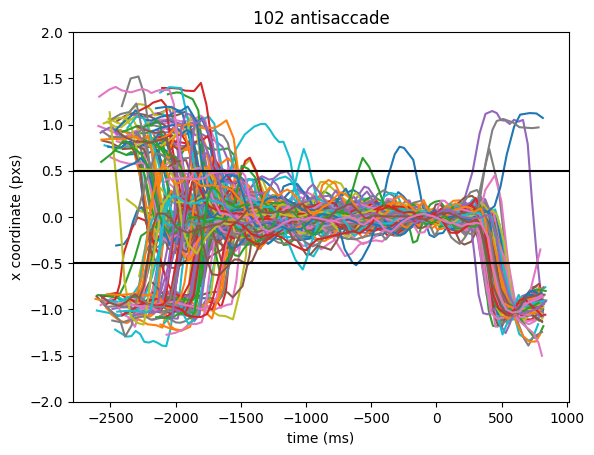

---
92


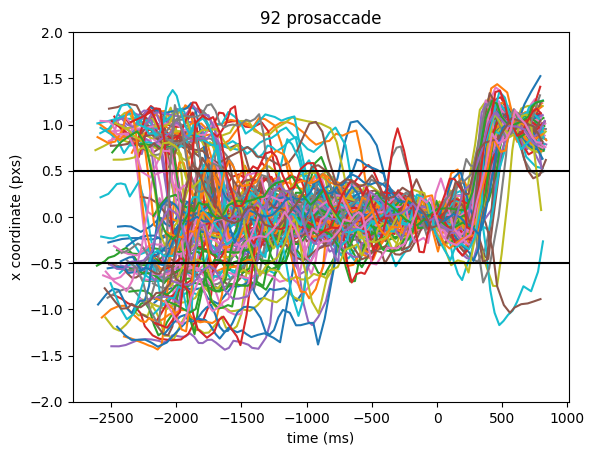

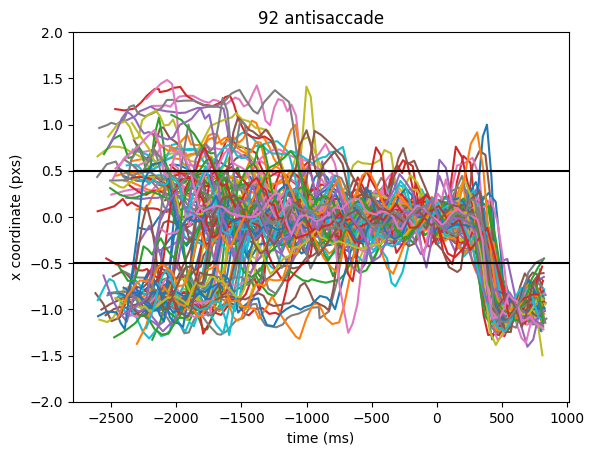

---
105


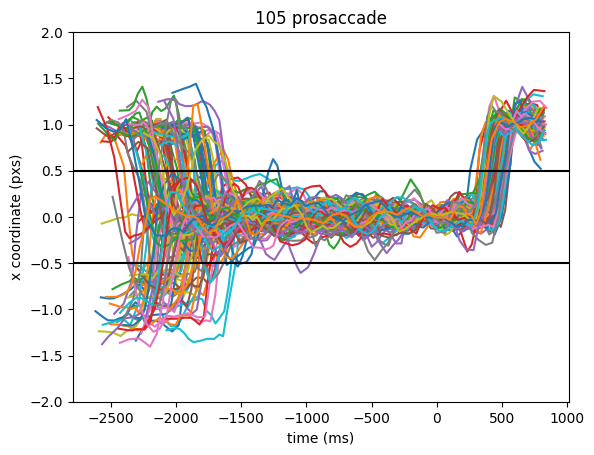

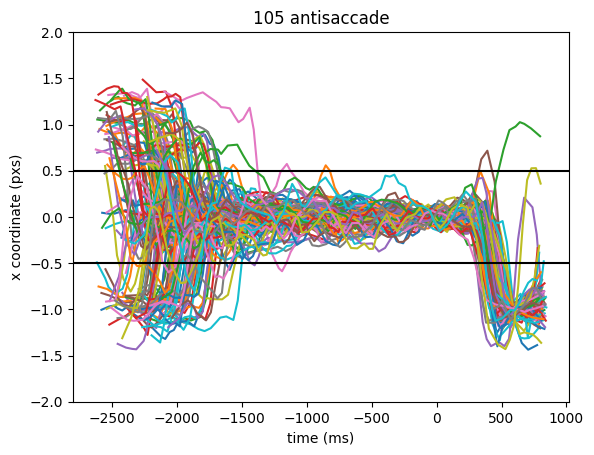

---
98


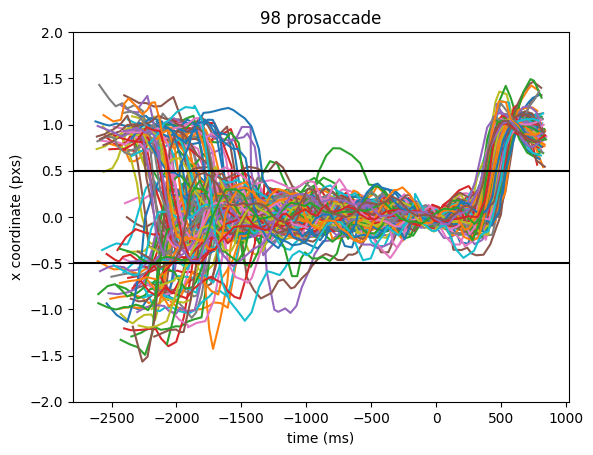

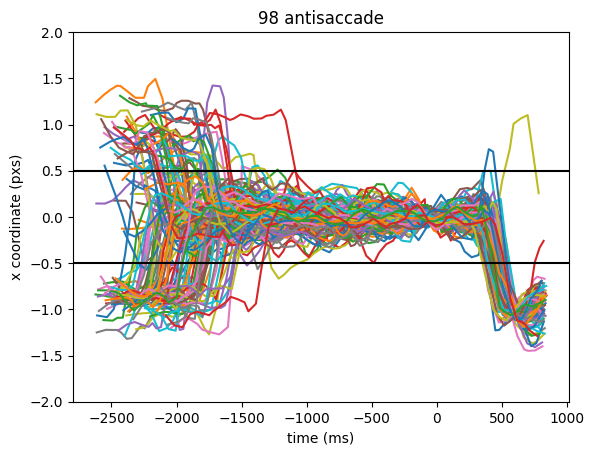

---
100


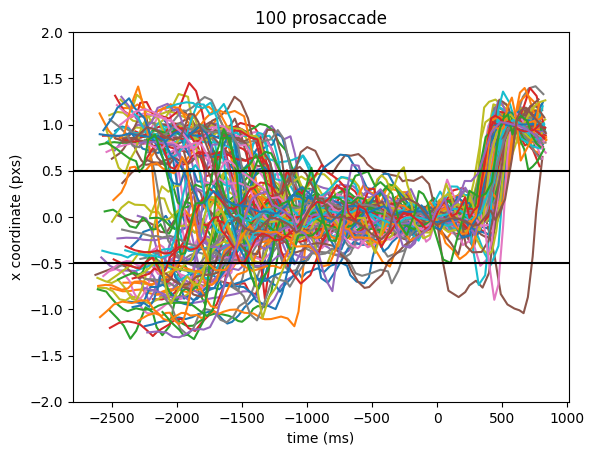

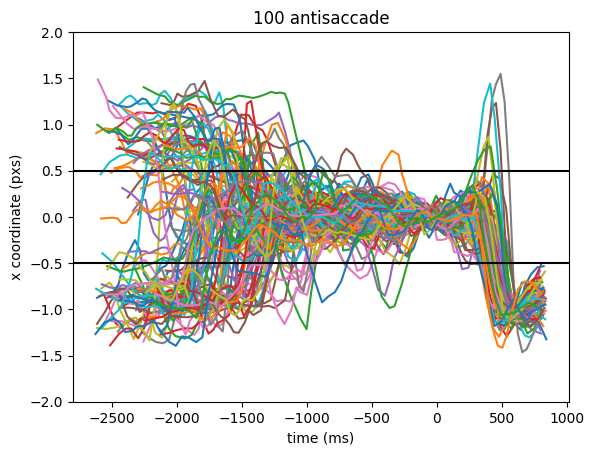

---
103


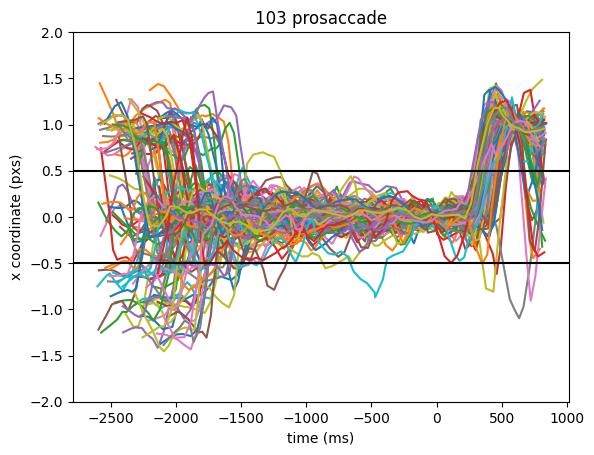

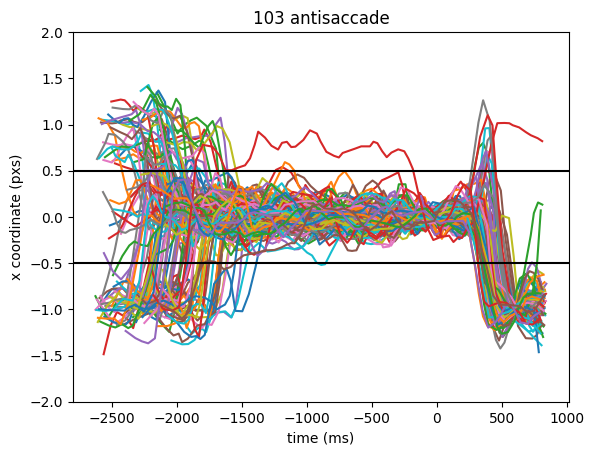

In [ ]:
# Plot all subjects
for file in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(file).split('/')[-1].split('.')[0].split('_')[-1]
    print(suj)
    one_subject(df_processed_signal, suj, 'prosaccade')
    one_subject(df_processed_signal, suj, 'antisaccade')

In [ ]:
# Podemos poner 0 - 150 
# Graficar solo los eerrores

# Calcular para cada trial correcto o incorrecto y el tiempo (y promedios +- desvio)
# Tablita cmo en la tesis (2 porcentajes y 4 tiempos)


In [152]:
# Tiempos en el experimento (ms)

# Inter-trial time (ITI) = 925
# Prensentacion de la cue de tipo de tarea =  getRandomIntInclusive(900, 1500) -> es variable!
# Presentacion del cuadrado central que es igual para todos (cue sin informacion) = 200
# tiempo durante el que aparece la visualCue = 150 
# Tiempo para responder (responseAwait) = 650

925 + 1500 + 200 + 150 + 650

3425